## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

- В колонках датасета содержатся следующие данные:
- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.
- На основе данных нужно предсказать медианную стоимость дома в жилом массиве — median_house_value

In [1]:
#импортируем необходимые библиотеки
import pandas as pd 
import numpy as np
import seaborn as sns

#импортируем pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

#импортируем spark инструменты
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import col, isnan, when, count

#фиксируем случайное состояние
RANDOM_SEED = 2022

In [2]:
#создаем спарк сессию
spark = SparkSession.builder \
                    .master("local") \
                    .appName("price prediction") \
                    .getOrCreate()

In [3]:
#загружаем данные
df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)
#df.toPandas().to_csv('housing.csv', index=False)

# Знакомство с данными

In [4]:
#типы данных pyspark
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [5]:
#типы данных pyspark
df.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string')]

In [6]:
#смотрим размер таблицы
(df.count(), len(df.columns))

(20640, 10)

In [7]:
#считаем пропуски
df.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df.columns]).collect()

[Row(longitude=0, latitude=0, housing_median_age=0, total_rooms=0, total_bedrooms=207, population=0, households=0, median_income=0, median_house_value=0, ocean_proximity=0)]

In [8]:
df.select(F.avg('total_bedrooms')).show()

+-------------------+
|avg(total_bedrooms)|
+-------------------+
|  537.8705525375618|
+-------------------+



In [9]:
#посмотрим медиану
df.approxQuantile('total_bedrooms', [0.5], 0)

[435.0]

- заполним пропуски медианой, чтобы постараться избежать сильного искажения данных, т.к относительно среднего она меньше

In [10]:
df.approxQuantile('total_bedrooms', [0.5], 0)

[435.0]

In [11]:
#заполним пропуски медианой
df = df.na.fill(value=df.approxQuantile('total_bedrooms', [0.5], 0)[0], 
                subset='total_bedrooms')

In [12]:
#проверим
df.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df.columns]).collect()

[Row(longitude=0, latitude=0, housing_median_age=0, total_rooms=0, total_bedrooms=0, population=0, households=0, median_income=0, median_house_value=0, ocean_proximity=0)]

In [13]:
#описательная статистика
df.describe().toPandas() 

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,536.8388565891473,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,419.39187792168866,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [14]:
#посмотрим срез
df.filter(F.col('total_rooms') == 39320.0).toPandas() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND


- Так как это жилые массивы думаю что ничего такого в этих значения нет

<AxesSubplot:ylabel='ocean_proximity'>

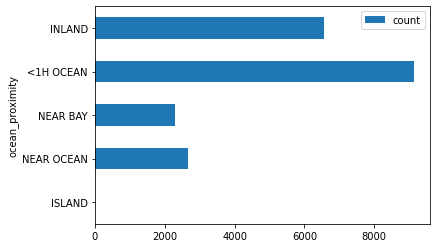

In [15]:
#посмотрим где больше жил массивов
df.groupBy("ocean_proximity").count().toPandas().plot.barh(x='ocean_proximity')

- `ISLAND` - остров
- `NEAR OCEAN` - рядом с океаном
- `NEAR BAY` - рядом с заливом
- `<1H OCEAN` менее одного часа да океана
- `INLAND` - скорее всего удаленный от моря

<AxesSubplot:ylabel='Frequency'>

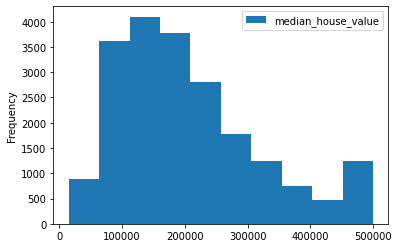

In [16]:
#распределение целевой переменной
df.select("median_house_value").toPandas().plot.hist()

In [17]:
#проверим на дубликаты, если длинна не равна, то False
df.distinct().count() == df.count()

True

In [18]:
# посмотрим кол-во проживающих по близости к океану
df.groupBy('ocean_proximity').agg(F.sum('population')).show()

+---------------+---------------+
|ocean_proximity|sum(population)|
+---------------+---------------+
|         ISLAND|         3340.0|
|     NEAR OCEAN|      3598955.0|
|       NEAR BAY|      2817427.0|
|      <1H OCEAN|    1.3889374E7|
|         INLAND|      9112744.0|
+---------------+---------------+



In [19]:
# посчитаем агрегирующие метрики
df.groupBy("ocean_proximity").agg(F.count('median_house_value'),
                                 F.mean('median_house_value')).show()

+---------------+-------------------------+-----------------------+
|ocean_proximity|count(median_house_value)|avg(median_house_value)|
+---------------+-------------------------+-----------------------+
|         ISLAND|                        5|               380440.0|
|     NEAR OCEAN|                     2658|     249433.97742663656|
|       NEAR BAY|                     2290|     259212.31179039303|
|      <1H OCEAN|                     9136|     240084.28546409807|
|         INLAND|                     6551|     124805.39200122119|
+---------------+-------------------------+-----------------------+



**Вывод:**
- Познакомились с таблицей: заменили пропуски в столбце 'total_bedrooms' медианой, посмотрели описательную статистику, ничего не обычного не нашли. 
- Больше всего человек 13 млн. проживает в менее 1 часа до океана, меньше всего на острове 3тыс
- Скорее всего престижнее жить на острове, т.к среднее при 5 элементах больше чем у остальных, значит дома там дорогие
- Посмотрели распределение целевого признака, распределение немного скошено влево, в нашей задаче это значит что больше не дорогих домов чем дорогих относительно средней стоимости

# Подготовка данных
<a id='start'></a>

In [20]:
df.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



In [21]:
#выбираем признаки для дальнейшей обработки
numerical_cols  = ['longitude','latitude','housing_median_age',
                   'total_rooms','total_bedrooms','population','households',
                   'median_income']
#целевой признак
target = 'median_house_value' 

In [22]:
#разделяем данные в соотношении 80/20
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print('train:',train_data.count(), 'test:',test_data.count())

train: 16418 test: 4222


In [23]:
#создаем вектор признаков
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

In [24]:
#тестовая выборка
test_data = numerical_assembler.transform(test_data)
#обучающая
train_data = numerical_assembler.transform(train_data)

In [25]:
#тестовая выборка
test_data.select("numerical_features").collect()[:3]

[Row(numerical_features=DenseVector([-124.3, 41.84, 17.0, 2677.0, 531.0, 1244.0, 456.0, 3.0313])),
 Row(numerical_features=DenseVector([-124.23, 40.81, 52.0, 1112.0, 209.0, 544.0, 172.0, 3.3462])),
 Row(numerical_features=DenseVector([-124.21, 40.75, 32.0, 1218.0, 331.0, 620.0, 268.0, 1.6528]))]

In [26]:
#обучающая
train_data.select("numerical_features").collect()[:3]

[Row(numerical_features=DenseVector([-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 270.0, 3.0147])),
 Row(numerical_features=DenseVector([-124.3, 41.8, 19.0, 2672.0, 552.0, 1298.0, 478.0, 1.9797])),
 Row(numerical_features=DenseVector([-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, 465.0, 2.5179]))]

In [27]:
standardScaler = StandardScaler(inputCol='numerical_features', 
                                outputCol='numerical_features_scaled')

In [28]:
#тестовая выборка
test_data = standardScaler.fit(train_data).transform(test_data)
#обучающая
train_data = standardScaler.fit(train_data).transform(train_data)

In [29]:
#тестовая выборка
test_data.select('numerical_features_scaled').collect()[:3]

[Row(numerical_features_scaled=DenseVector([-61.928, 19.573, 1.3509, 1.2201, 1.2668, 1.0895, 1.1885, 1.5989])),
 Row(numerical_features_scaled=DenseVector([-61.8931, 19.0912, 4.1323, 0.5068, 0.4986, 0.4764, 0.4483, 1.765])),
 Row(numerical_features_scaled=DenseVector([-61.8831, 19.0631, 2.543, 0.5551, 0.7896, 0.543, 0.6985, 0.8718]))]

In [30]:
#обучающая выборка
train_data.select('numerical_features_scaled').collect()[:3]

[Row(numerical_features_scaled=DenseVector([-61.9529, 18.9649, 4.1323, 0.8295, 0.7157, 0.7059, 0.7037, 1.5901])),
 Row(numerical_features_scaled=DenseVector([-61.928, 19.5543, 1.5099, 1.2178, 1.3169, 1.1368, 1.2459, 1.0442])),
 Row(numerical_features_scaled=DenseVector([-61.913, 19.035, 2.8608, 1.0706, 1.2596, 1.0457, 1.212, 1.3281]))]

### Постройте две модели линейной регрессии на разных наборах данных

**Используя только числовые переменные, исключив категориальные**

In [31]:
#создаем вектор стандартизированных признаков
all_features = ['numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 

In [32]:
#тестовая выборка
test_data = final_assembler.transform(test_data)
#обучающая
train_data = final_assembler.transform(train_data)

In [33]:
#обучающая выборка
train_data.select('features').collect()[:3]

[Row(features=DenseVector([-61.9529, 18.9649, 4.1323, 0.8295, 0.7157, 0.7059, 0.7037, 1.5901])),
 Row(features=DenseVector([-61.928, 19.5543, 1.5099, 1.2178, 1.3169, 1.1368, 1.2459, 1.0442])),
 Row(features=DenseVector([-61.913, 19.035, 2.8608, 1.0706, 1.2596, 1.0457, 1.212, 1.3281]))]

In [34]:
#тестовая выборка
train_data.select('features').collect()[:3]

[Row(features=DenseVector([-61.9529, 18.9649, 4.1323, 0.8295, 0.7157, 0.7059, 0.7037, 1.5901])),
 Row(features=DenseVector([-61.928, 19.5543, 1.5099, 1.2178, 1.3169, 1.1368, 1.2459, 1.0442])),
 Row(features=DenseVector([-61.913, 19.035, 2.8608, 1.0706, 1.2596, 1.0457, 1.212, 1.3281]))]

In [35]:
#создаем модель
lr = LinearRegression(labelCol=target, featuresCol='features')
#обучаем модель
model = lr.fit(train_data) 

23/06/02 11:37:25 WARN Instrumentation: [2943c966] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 11:37:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/02 11:37:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/06/02 11:37:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/06/02 11:37:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [36]:
#делаем предсказания
predictions = model.transform(test_data)

In [37]:
#посмотрим на предсказание
predictedLabes = predictions.select('median_house_value', 'prediction')
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|101397.02412080672|
|           50800.0|183325.89393649017|
|           58100.0|109609.16753835836|
|           68400.0| 80433.62265060423|
|           72200.0| 129998.2662690985|
|           67000.0|120450.76353514753|
|           81300.0|118114.86732555227|
|           70500.0|130753.57020050427|
|           60000.0|110063.38701279089|
|          109400.0|118242.89485415397|
|           74100.0|117747.20196674112|
|           74700.0|134462.40087586502|
|           90000.0| 176029.6403315412|
|          104200.0|166600.68830726342|
|           74100.0| 123045.0864237817|
|           67500.0|113810.87810525578|
|          103100.0|-8400.804346143268|
|           92500.0|140926.28127247933|
|          128100.0| 191273.7222844963|
|           99600.0|152718.59374417737|
+------------------+------------------+
only showing top 20 rows



In [38]:
#Оценщик для регрессии
evaluator = RegressionEvaluator()
#устанавливаем столбец предсказаний
evaluator.setPredictionCol('prediction')
#устанавливаем целевой столбец
evaluator.setLabelCol('median_house_value')

RegressionEvaluator_1d158a8681af

In [39]:
print('Корень из средней квадратичной ошибки - RMSE')
print(evaluator.evaluate(predictedLabes, {evaluator.metricName: 'rmse'}))

Корень из средней квадратичной ошибки - RMSE
69212.86125298042


In [40]:
print('Коэффициент детерминации - R2')
print(evaluator.evaluate(predictedLabes, {evaluator.metricName: "r2"}))

Коэффициент детерминации - R2
0.6461729709922107


In [41]:
print('Средняя абсолютная ошибка - MAE')
print(evaluator.evaluate(predictedLabes, {evaluator.metricName: 'mae'}))

Средняя абсолютная ошибка - MAE
50866.55977336322


**2. Используя все данные из файла**

In [42]:
#разделяем данные
train_data_2, test_data_2 = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print('train:',train_data_2.count(), 'test:',test_data_2.count()) 

train: 16418 test: 4222


In [43]:
# категориальные столбцы
categorical_cols = ['ocean_proximity']

In [44]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols])

#обрабатываем невидимые метки(не получается без него посчитать метрику со всеми признаками)
indexer.setHandleInvalid('keep')#scip

StringIndexer_32980612dc68

In [45]:
#тестовая выборка
test_data_2 = indexer.fit(train_data_2).transform(test_data_2)
#обучающая
train_data_2 = indexer.fit(train_data_2).transform(train_data_2)

In [46]:
#проверим тестовую
test_data_2.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_proximity_idx']

In [47]:
#проверим обучающую
train_data_2.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_proximity_idx']

In [48]:
#закодировали дополнительно с помощью OHE
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])


In [49]:
#тестовая выборка
test_data_2 = encoder.fit(train_data_2).transform(test_data_2)
#обучающая
train_data_2 = encoder.fit(train_data_2).transform(train_data_2)

In [50]:
#проверим тестовую
test_data_2.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_proximity_idx',
 'ocean_proximity_ohe']

In [51]:
#столбцы для стандартизирования и создания вектора признаков
numerical_cols  = ['longitude','latitude','housing_median_age',
                   'total_rooms','total_bedrooms','population','households',
                   'median_income','ocean_proximity_ohe']

In [52]:
#создадим вектор признаков
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features_2')

#тестовая выборка
test_data_2 = numerical_assembler.transform(test_data_2)
#обучающая
train_data_2 = numerical_assembler.transform(train_data_2)

In [53]:
#тестовая выборка
train_data_2.select('numerical_features_2').collect()[:3]

[Row(numerical_features_2=DenseVector([-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 270.0, 3.0147, 0.0, 0.0, 1.0, 0.0])),
 Row(numerical_features_2=DenseVector([-124.3, 41.8, 19.0, 2672.0, 552.0, 1298.0, 478.0, 1.9797, 0.0, 0.0, 1.0, 0.0])),
 Row(numerical_features_2=DenseVector([-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, 465.0, 2.5179, 0.0, 0.0, 1.0, 0.0]))]

In [54]:
#обучающая выборка
train_data_2.select('numerical_features_2').collect()[:3]

[Row(numerical_features_2=DenseVector([-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 270.0, 3.0147, 0.0, 0.0, 1.0, 0.0])),
 Row(numerical_features_2=DenseVector([-124.3, 41.8, 19.0, 2672.0, 552.0, 1298.0, 478.0, 1.9797, 0.0, 0.0, 1.0, 0.0])),
 Row(numerical_features_2=DenseVector([-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, 465.0, 2.5179, 0.0, 0.0, 1.0, 0.0]))]

In [55]:
#стандартизируем вектор признаков
standardScaler = StandardScaler(inputCol='numerical_features_2',
                                                           outputCol='numerical_features_scaled_2')

In [56]:
#тестовая выборка
test_data_2 = standardScaler.fit(train_data_2).transform(test_data_2)
#обучающая
train_data_2 = standardScaler.fit(train_data_2).transform(train_data_2)

In [57]:
#тестовая выборка
test_data_2.select('numerical_features_scaled_2').take(3)

[Row(numerical_features_scaled_2=DenseVector([-61.928, 19.573, 1.3509, 1.2201, 1.2668, 1.0895, 1.1885, 1.5989, 0.0, 0.0, 2.9814, 0.0])),
 Row(numerical_features_scaled_2=DenseVector([-61.8931, 19.0912, 4.1323, 0.5068, 0.4986, 0.4764, 0.4483, 1.765, 0.0, 0.0, 2.9814, 0.0])),
 Row(numerical_features_scaled_2=DenseVector([-61.8831, 19.0631, 2.543, 0.5551, 0.7896, 0.543, 0.6985, 0.8718, 0.0, 0.0, 2.9814, 0.0]))]

In [58]:
#обучающая выборка
train_data_2.select('numerical_features_scaled_2').take(3)

[Row(numerical_features_scaled_2=DenseVector([-61.9529, 18.9649, 4.1323, 0.8295, 0.7157, 0.7059, 0.7037, 1.5901, 0.0, 0.0, 2.9814, 0.0])),
 Row(numerical_features_scaled_2=DenseVector([-61.928, 19.5543, 1.5099, 1.2178, 1.3169, 1.1368, 1.2459, 1.0442, 0.0, 0.0, 2.9814, 0.0])),
 Row(numerical_features_scaled_2=DenseVector([-61.913, 19.035, 2.8608, 1.0706, 1.2596, 1.0457, 1.212, 1.3281, 0.0, 0.0, 2.9814, 0.0]))]

In [59]:
#вектор признаков
all_features = ['numerical_features_scaled_2']
final_assembler = VectorAssembler(inputCols=all_features, outputCol='features_2') 

In [60]:
#тестовая выборка
test_data_2 = final_assembler.transform(test_data_2)
#обучающая
train_data_2 = final_assembler.transform(train_data_2)

In [61]:
#обучающая выборка
train_data_2.select('features_2').take(3)

[Row(features_2=DenseVector([-61.9529, 18.9649, 4.1323, 0.8295, 0.7157, 0.7059, 0.7037, 1.5901, 0.0, 0.0, 2.9814, 0.0])),
 Row(features_2=DenseVector([-61.928, 19.5543, 1.5099, 1.2178, 1.3169, 1.1368, 1.2459, 1.0442, 0.0, 0.0, 2.9814, 0.0])),
 Row(features_2=DenseVector([-61.913, 19.035, 2.8608, 1.0706, 1.2596, 1.0457, 1.212, 1.3281, 0.0, 0.0, 2.9814, 0.0]))]

In [62]:
#тестовая выборка
test_data_2.select('features_2').take(3)

[Row(features_2=DenseVector([-61.928, 19.573, 1.3509, 1.2201, 1.2668, 1.0895, 1.1885, 1.5989, 0.0, 0.0, 2.9814, 0.0])),
 Row(features_2=DenseVector([-61.8931, 19.0912, 4.1323, 0.5068, 0.4986, 0.4764, 0.4483, 1.765, 0.0, 0.0, 2.9814, 0.0])),
 Row(features_2=DenseVector([-61.8831, 19.0631, 2.543, 0.5551, 0.7896, 0.543, 0.6985, 0.8718, 0.0, 0.0, 2.9814, 0.0]))]

In [63]:
# создаем модель
lr_2 = LinearRegression(labelCol=target, featuresCol='features_2')
# обучаем модель
model_2 = lr_2.fit(train_data_2) 

23/06/02 11:37:38 WARN Instrumentation: [d4b45a6b] regParam is zero, which might cause numerical instability and overfitting.


In [64]:
# делаем предсказание
predictions_2 = model_2.transform(test_data_2)

In [65]:
#смотрим что получилось
predictedLabes_2 = predictions_2.select('median_house_value', 'prediction')
predictedLabes_2.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 152990.3428801275|
|           50800.0|214967.33393507916|
|           58100.0|142714.13233401952|
|           68400.0| 132483.0081101749|
|           72200.0|164098.81098097004|
|           67000.0|154443.31802929193|
|           81300.0|152868.87818166288|
|           70500.0|164579.07351704407|
|           60000.0| 142736.4139682413|
|          109400.0|171312.63302467065|
|           74100.0|150617.86628104374|
|           74700.0| 167873.1090384489|
|           90000.0| 209844.4108503312|
|          104200.0|200499.67555249017|
|           74100.0|157152.58155363053|
|           67500.0|148318.55209510913|
|          103100.0| 47444.61771324603|
|           92500.0|166737.19970901497|
|          128100.0|222099.36990126967|
|           99600.0|187273.61884772917|
+------------------+------------------+
only showing top 20 rows



In [66]:
print('Корень из средней квадратичной ошибки - RMSE')
print(evaluator.evaluate(predictedLabes_2, {evaluator.metricName: 'rmse'}))

Корень из средней квадратичной ошибки - RMSE
73354.97850934371


In [67]:
print('Коэффициент детерминации - R2')
print(evaluator.evaluate(predictedLabes_2, {evaluator.metricName: 'r2'}))

Коэффициент детерминации - R2
0.6025554119983945


In [68]:
print('Средняя абсолютная ошибка - MAE')
print(evaluator.evaluate(predictedLabes_2, {evaluator.metricName: 'mae'}))

Средняя абсолютная ошибка - MAE
50593.22549106409


In [69]:
#завершаем
spark.stop()

# Анализ результатов

| Числовые признаки  | Все признаки |
| ------------- | ------------- |
| **RMSE - 69.212**  | **RMSE - 73.354** |
 | **R2 - 0.6461**  | **R2 - 0.6025** |
| **MAE - 50.866** | **MAE - 50.593** |

- По результатам исследования можно сказать, что значимых различий в метриках нет.
- Исследую метрику RMSE, видно, что в каждом объекте мы ошибаемся на 70 тыс usd используя числовые признаки и еще больше ошибаемся при использовании с категориальным признаком, т.к это корень из квадрата разниц в целевой переменной скорее всего присутствуют большие значения, которые квадрат метрики увеличивает, поэтому предлагаю присмотреться к метрике MAE и R2.
- По MAE можно сказать, что в каждом объекте мы ошибаемся на 50 тыс usd что тоже достаточно много
- Если смотреть на метрику R2, получается что наша модель учитывает 64% изменчивости целевой переменной остальные 36% она не понимает, это значит, что наша модель обладает слабой обобщающей способностью

### Общий вывод
- Мы изучили наши данные с помощью методов pyspark и стандартных библиотек, немного предобработали данные, визуализировали, узнали, что больше всего домов в жилмассивах находится в менее одного часа до океана(неизвестно пешком или на авто), меньше всего на острове
- Посмотрели распределение целевой переменной - распределение нормальное немного скошенно влево, в нашей задаче это значит что больше не дорогих домов чем дорогих относительно среднего
- Так же предобработали данные для модели:
     - перевели категориальный признак в числовой
     - стандартизировали данные
- Создали вектор признаков, разделили данные на train/test и обучили модель на двух разных наборах данных с учетом категориальной переменной и без
- Оценили модель с помощью метрик RMSE, R2, MAE
- Проанализировав полученный результаты, можно сказать что значимых различий с при обучении с учетом категориальной переменной и без - нет
| Числовые признаки  | Все признаки |
| ------------- | ------------- |
| **RMSE - 69.212**  | **RMSE - 73.354** |
 | **R2 - 0.6461**  | **R2 - 0.6025** |
| **MAE - 50.866** | **MAE - 50.593** |
- В таблице видно, что наша модель имеет очень большую ошибку по каждому объекту 50 тыс MAE и 70 тыс RMSE, предположим что из-за квадрата разницы в нашем случает метрика RMSE не показательна, тогда метрики R2 и MAE дадут уверенность в том что нашей модели требуется доработка.